In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

tf.config.threading.set_intra_op_parallelism_threads(64)  # Maximize intra-op parallelism across 64 CPUs
tf.config.threading.set_inter_op_parallelism_threads(64)
# Load the data
X = pd.read_csv('x_imputed.csv')
y = pd.read_csv('response.csv')

# Replace missing values in y with NaN
y = y.replace("?", np.nan)  # If missing values are marked with "?" in the dataset
y_numeric = y.select_dtypes(include = "number") # Remove 'statecounty'
# Normalize X (remove the 'statecounty' column)
X_numeric = X.select_dtypes(include = 'number')  # Remove 'statecounty'
X_numeric.replace([np.inf, -np.inf], 0, inplace=True)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2, random_state=42)


In [3]:
# Custom masked loss function to handle missing values in y
def masked_loss(y_true, y_pred):
    mask = tf.math.is_finite(y_true)  # Create a mask to ignore NaNs
    y_true_masked = tf.where(mask, y_true, 0.0)  # Replace NaNs with 0.0 for loss calculation
    y_pred_masked = tf.where(mask, y_pred, 0.0)
    return tf.reduce_mean(tf.square(y_true_masked - y_pred_masked))

def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))

    # Tune the number of layers and units in each layer
    for i in range(hp.Int('num_layers', 2, 3)):  # Narrow to between 2 and 3 layers
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                     min_value=128,
                                                     max_value=256,  # Narrow units range
                                                     step=64),
                                        activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_' + str(i),
                                                   min_value=0.2,
                                                   max_value=0.4,
                                                   step=0.1)))

    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),  # Narrow learning rate
                  loss=masked_loss,
                  metrics=['mae'])
    return model


# Hyperparameter tuning using  RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='multi_target_hyperparam_tuning',
    max_consecutive_failed_trials=10
)


Reloading Tuner from my_dir/multi_target_hyperparam_tuning/tuner0.json


In [ ]:

# shap graph starts
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64)

best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Loss: {loss}, Test MAE: {mae}")

best_model.save('best_multi_target_model.h5')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17619.4277 - mae: 71.6576  


Best Model Test Loss: 15168.595703125, Test MAE: 70.56047058105469


In [5]:
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt

# Load the saved model
best_model = load_model('best_multi_target_model.h5', compile=False)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Use only a small subset for SHAP calculation
background = X_train.sample(50, random_state=42)
X_test_subset = X_test[:10]

explainer = shap.KernelExplainer(best_model.predict, background)
shap_values = explainer.shap_values(X_test_subset)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7232/7232 ━━━━━━━━━━━━━━━━━━━━ 4s 596us/step


 10%|█         | 1/10 [00:57<08:33, 57.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
7266/7266 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step  


 20%|██        | 2/10 [01:45<06:56, 52.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
7232/7232 ━━━━━━━━━━━━━━━━━━━━ 4s 585us/step


 30%|███       | 3/10 [02:36<06:01, 51.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
7232/7232 ━━━━━━━━━━━━━━━━━━━━ 6s 749us/step


 40%|████      | 4/10 [03:40<05:37, 56.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
7232/7232 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 50%|█████     | 5/10 [05:06<05:34, 66.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
7232/7232 ━━━━━━━━━━━━━━━━━━━━ 7s 939us/step


 60%|██████    | 6/10 [06:10<04:25, 66.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
7232/7232 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 70%|███████   | 7/10 [07:40<03:41, 73.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
7232/7232 ━━━━━━━━━━━━━━━━━━━━ 6s 857us/step


 80%|████████  | 8/10 [09:12<02:39, 79.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
7232/7232 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


 90%|█████████ | 9/10 [10:29<01:18, 78.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
7232/7232 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


100%|██████████| 10/10 [11:45<00:00, 70.56s/it]


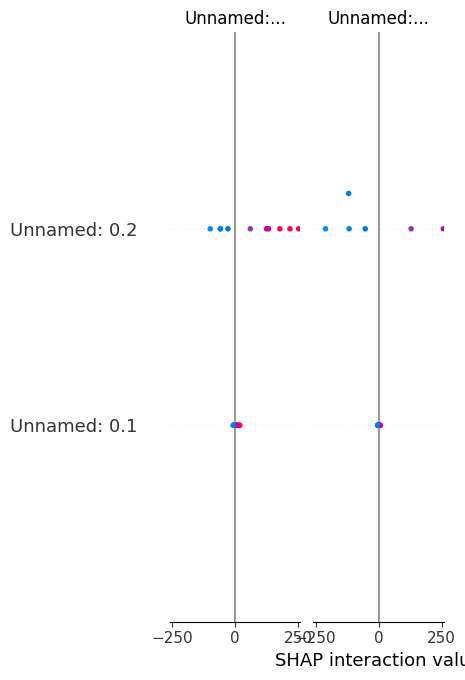

In [8]:
shap.summary_plot(shap_values, X_test_subset, feature_names=X_train.columns)